In [1]:
%load_ext autoreload
%autoreload 2

from mapper import map_anywhere as mpa
from mapper import graph_node, build_node_graph, extract_segments, filter_tree, break_loops
from osrm_interface import osrm_handler

import cartopy
from datetime import datetime
import osmium
import shapely.geometry as geom
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import numpy as np
import pickle
import time

In [2]:
# Need to extract segments
class segment_t():
    def __init__(self, seg_list, nodes_lonlat):
        # self.weight = np.log(seg_list[0] + 1)
        self.weight = (seg_list[0]) ** 0.25
        self.nodes = seg_list[1]
        self.lon = [nodes_lonlat[n][0] for n in self.nodes]
        self.lat = [nodes_lonlat[n][1] for n in self.nodes]

In [3]:
# Simple example
dest_latlon = (47.635639, -122.105031) # Reid and Emma
# dest_latlon = (47.752200, -122.317425) # Rachel and Nikole
# dest_latlon = (36.970433, -122.007613) # Cayla

n_sample = 10000
num_workers = 14

# width = 1 # deg
# height = 1 # deg

width = height = None
# Washington
nw_latlon = (49.0001, -124.8)
se_latlon = (45.54, -116.91)
# # Denver West
# nw_latlon = (48.954886, -125.652977)
# se_latlon = (31.133894, -105.457201)
# # West
# nw_latlon = (48.954886, -125.652977)
# se_latlon = (36.26, -109.1)
# # USA
# nw_latlon = (48.954886, -125.652977)
# se_latlon = (24.54, -66.93)
# # Cayla
# nw_latlon = (38.51, -123.26)
# se_latlon = (36.13, -120.14)

start = time.time()
router = mpa(parallel_workers=num_workers)
router.set_destination(dest_latlon)
if width is not None:
    router.set_bounding_box_centered(width, height)
else:
    router.set_bounding_box(nw_latlon, se_latlon)
router.sample_nodes(n_sample)
print("Starting routing")
# router.sample_routes(geometry=True)
router.thread_manager(geometry=True)
end = time.time()
print(f"Elapsed time: {end - start} seconds, {(end - start) / n_sample} seconds per route")

# 1000 points, washington only
# New multithread: Elapsed time: 6.354197025299072 seconds, 0.0063541970252990725 seconds per route
# Old multithread: Elapsed time: 10.311986207962036 seconds, 0.010311986207962037 seconds per route
# Single thread: Elapsed time: 22.201290369033813 seconds, 0.022201290369033812 seconds per route

# 10k points, washington only
# New multithread: Elapsed time: 47.136099338531494 seconds, 0.004713609933853149 seconds per route
# Old multithread: Elapsed time: 102.5457603931427 seconds, 0.01025457603931427 seconds per route
# Single thread: Elapsed time: 221.4559769630432 seconds, 0.022145597696304323 seconds per route

Starting routing
Merging result 1
Merging result 2
Merging result 3
Merging result 4
Merging result 5
Merging result 6
Merging result 7
Merging result 8
Merging result 9
Merging result 10
Merging result 11
Merging result 12
Merging result 13
Merging result 14
Elapsed time: 6.354197025299072 seconds, 0.0063541970252990725 seconds per route


In [4]:
print(len(router.node_dict))
print(len(router.segment_counts))
print(len(router.lonlat_dict))

15382
978411
1012255


In [5]:
tree = build_node_graph(router.segment_counts)
filter_tree(tree)
segments = extract_segments(tree)
segments += break_loops(tree)
segments += extract_segments(tree)

Tree is not empty!!!
Found a loop at node 48733552
Found a loop at node 30178936
Found a loop at node 6758529875
Found a loop at node 4272310025
Found a loop at node 4272310012
Found a loop at node 53107880
Found a loop at node 243582114
Found a loop at node 47497801
Found a loop at node 7168486026


In [6]:
node_set = set()
for n1n2 in router.segment_counts:
    n1, n2 = n1n2
    node_set.add(n1)
    node_set.add(n2)

In [7]:
nodes_lonlat = router.lonlat_dict
k = next(iter(nodes_lonlat))
nodes_lonlat[k]

[-123.344194, 46.151957]

In [8]:
segment_list = [segment_t(s, nodes_lonlat) for s in segments]

In [9]:
# Cache things for future use to save recomputation
save_dict = {}
save_dict["segment_list"] = segment_list
save_dict["specs"] = {"dest_latlon":dest_latlon, "width":width, "height":height, "n_sample":n_sample}
if width is None:
    save_dict["specs"]["nw_latlon"] = nw_latlon
    save_dict["specs"]["se_latlon"] = se_latlon
    width = se_latlon[1] - nw_latlon[1]
    height = nw_latlon[0] - se_latlon[0]


save_filename = f"{datetime.now().strftime("%Y.%m.%d.%H.%M")}_{dest_latlon[0]},{dest_latlon[1]}_{width}deg_width_{height}deg_height_{n_sample}samples.p"
with open("cache/" + save_filename, 'wb') as f:
    print(f"Savinng to {save_filename}") 
    pickle.dump(save_dict, f)

Savinng to 2025.11.09.11.15_47.635639,-122.105031_7.890000000000001deg_width_3.460100000000004deg_height_20000samples.p


In [10]:
load = False
if load:
    load_filename = "2025.10.17.13.06_47.635639,-122.105031_58.722977deg_width_24.414886000000003deg_height_40000samples.p"
    # load_filename = "2025.10.17.13.47_47.635639,-122.105031_58.722977deg_width_24.414886000000003deg_height_10000samples.p"
    with open("cache/" + load_filename, 'rb') as f:
        print(f"Loadinng from {load_filename}")
        save_dict = pickle.load(f)

        segment_list = save_dict["segment_list"]
        width = save_dict["specs"]['width']
        height = save_dict["specs"]['height']
        n_sample = save_dict["specs"]['n_sample']

        if "nw_latlon" in save_dict:
            nw_latlon = save_dict['specs']['nw_latlon']
            se_latlon = save_dict['specs']['se_latlon']
            width = se_latlon[1] - nw_latlon[1]
            height = nw_latlon[0] - se_latlon[0]

In [11]:
class albers_projection():
    def __init__(self, origin_lat = 40, origin_lon = -96):
        self.R = 1.0 # Normalized units
        self.phi_1 = 29.5 # Deg, first parallel
        self.phi_2 = 45.5 # Deg, second parallel
        self.origin_lat = origin_lat # Deg lat
        self.origin_lon = origin_lon # Deg, lon

        # Set up the initial values needed
        self.n = (np.sin(self.phi_1 * np.pi / 180) + np.sin(self.phi_2 * np.pi / 180)) / 2
        self.C = np.cos(self.phi_1 * np.pi / 180) ** 2 + 2 * self.n * np.sin(self.phi_1 * np.pi / 180)
        self.rho_0 = self.R / self.n * np.sqrt(self.C - 2 * self.n * np.sin(self.origin_lat * np.pi / 180))

    # Get the x/y coordinate given lat/lon in degrees
    def transform(self, lat, lon):
        theta = self.n * (lon - self.origin_lon)
        rho = self.R / self.n * np.sqrt(self.C - 2 * self.n * np.sin(lat * np.pi / 180))
        x = rho * np.sin(theta * np.pi / 180)
        y = self.rho_0 - rho * np.cos(theta * np.pi / 180)

        return x, y
        

In [12]:
class web_mercator():
    def __init__(self):
        self.zoom = 1

    def transform(self, lat, lon):
        x = self.zoom / (2 * np.pi) * (np.pi + lon * np.pi / 180)
        y = -1 * self.zoom / (2 * np.pi) * (np.pi - np.log(np.tan(np.pi / 4 + (lat * np.pi / 180) / 2)))

        return x, y

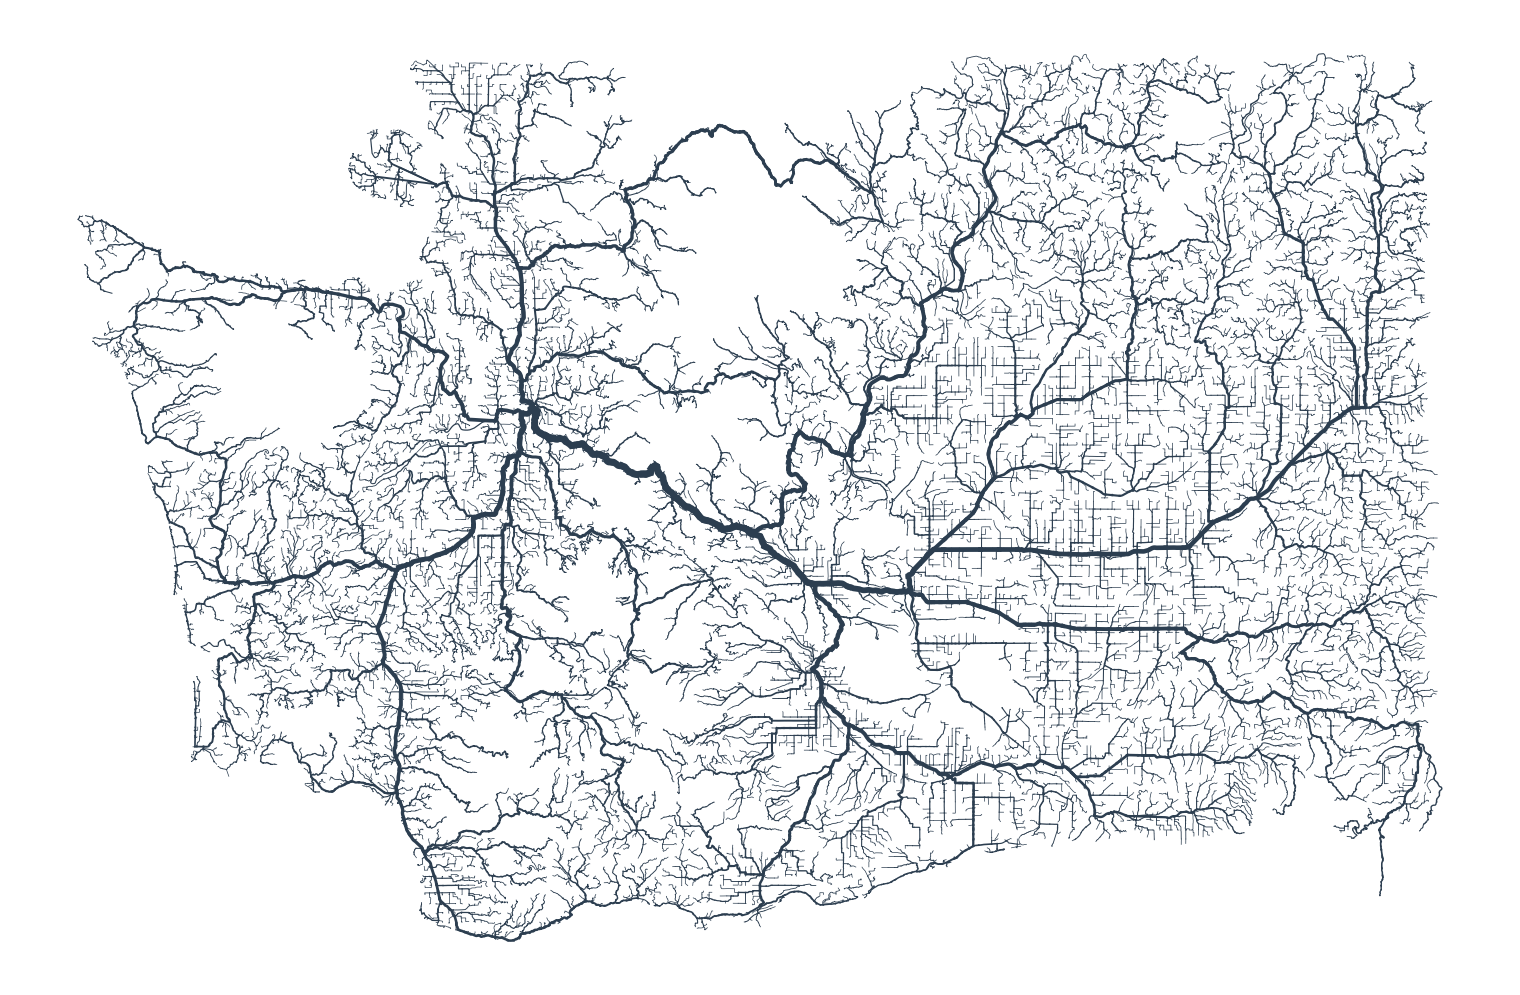

In [13]:
# Plot things, hopefully aesthetically nicely
fig, ax = plt.subplots(figsize=(15, 15), dpi=100)
ax.set_aspect('equal')

linewidth_scale = 0.5
transform = True
if transform:
    # tform = albers_projection()
    tform = web_mercator()
for segment in segment_list:
    if transform:
        plt_x, plt_y = tform.transform(lat=np.array(segment.lat), lon=np.array(segment.lon))
        plt.plot(plt_x, plt_y, color='#2C3E50', alpha=1.0, linewidth=segment.weight*linewidth_scale, antialiased=True)
    else:
        plt.plot(segment.lon, segment.lat, color='#2C3E50', alpha=1.0, linewidth=segment.weight*linewidth_scale, antialiased=True)

padding = 1.1
# if nw_latlon is not None:
#     pad_w = (se_latlon[1] - nw_latlon[1]) * padding / 2
#     pad_h = (nw_latlon[0] - se_latlon[0]) * padding / 2
#     plt.xlim([nw_latlon[1] - pad_w, se_latlon[1] + pad_w])
#     plt.ylim([se_latlon[0] - pad_h, se_latlon[0] + pad_h])
# else:
#     plt.xlim([dest_latlon[1] - padding * width/2, dest_latlon[1] + padding * width/2])
#     plt.ylim([dest_latlon[0] - padding * height/2, dest_latlon[0] + padding * height/2])

# plt.xticks(np.arange(-125, -65+5, 5))

# Styling for aesthetic output
ax.set_facecolor('#ECF0F1')  # Light background
ax.axis('off')
plt.tight_layout(pad=0)
plt.savefig('output.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [2]:
class WayNodeHandler(osmium.SimpleHandler):
    def __init__(self):
        super().__init__()
        self.nodes = {}
    
    def way(self, w):
        if 'highway' in w.tags:
            for n in w.nodes:
                self.nodes[n.ref] = (n.location.lon, n.location.lat)

In [4]:
handler = WayNodeHandler()
# handler.apply_file("washington-250930.osm.pbf", locations=True)
pbf_file = "us-west-250930.osm.pbf"
handler.apply_file(pbf_file, locations=True)

In [5]:
import pickle

file = f"{pbf_file}.p"

with open(file, 'wb') as f:
    pickle.dump(handler.nodes, f)

# Later, load instantly
with open(file, 'rb') as f:
    latlon_dict = pickle.load(f)